In [1]:
from BIFParser import *
import Factor

from random import uniform
import numpy as np
import pandas as pd
import copy
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure

from time import time

## Generate Nodes

Usamos esta função para fazer a criação dos nós, apartir do ficheiro dado. E esta função retorna um ficheiro bif contendo a configuração da rede. 

In [2]:
def generate_nodes(path):
    file = open(path)
    BIF = file.readlines()
    BIF = fixWhiteSpace(BIF)
    return parseBIF(BIF)

## SelectIndex

A função sample foi utilizada para criar uma amostra de acordo com os valores de probabilidade de cada nó.<br>
O selectIndex recebe um valor gerado de forma aleatoria utilizando uma distribuição uniforme e uma distribuição de probabilidade, e seleciona o index a que pertence o valor gerado.<br>
O getValue é uma função recursiva que calcula o indice do valor referente a variavel n, apartir do valor dos seus respectivos pais caso haja, caso não tenha pai(s) apanha apartir da probabilidade da variavel v. 

In [3]:
def selectIndex(dist, val):
    n = 0
    for i in range(len(dist)) :
        n += dist[i]
        if n>=val:
            return i

def getValue(rv, v, n):
    if(rv[n.getIndex()]!=None):
        return rv[n.getIndex()]
    if n.numParents() == 0:
        rv[n.getIndex()] = selectIndex(n.getDist().values()[0], v[n.getIndex()])
        return rv[n.getIndex()]
    key = ((n.getStates(), ))
    p_key = ()
    for p in n.getParents():
        p_key += (p.getStates()[getValue(rv, v, p)], )
    key+= (p_key, )
    rv[n.getIndex()] = selectIndex(n.getDist()[key], v[n.getIndex()])
    return rv[n.getIndex()]

def sample(nodes, node=None, val_index=None):
    v = [uniform(0,1) for n in nodes]
    rv = {n.getIndex(): None for n in nodes}
    if(node!=None and val_index!=None):
        rv[node.getIndex()] = val_index
    sample = []
    for n in nodes:
        sample.append(getValue(rv, v, n))
    return sample

## converge

É uma função que recebe os dados gerados e verifica se houve alteração inferior a .000001 nas duas últimas iterações para verificar se de facto os dados convergem.

In [4]:
def converge(data):
    if len(data)>1000:
        a = data[len(data)-1]
        b = data[len(data)-2]
        print a
        print b
        return False if np.abs(np.sum(a)-np.sum(b)) > .000001 else True
    return False

Essa seria a função que calcularia a probabilidade de acordo com a função dada no enunciado do trabalho. 

In [5]:
def hope(nodes, sample, n):
    b = 1.0
    a = 1.0
    
    for node in n.getChildren():
        key = (node.getStates(), )
        p_vals = ()
        for p in node.getParents():
            states = p.getStates()
            p_vals += (states[sample[p.getIndex()]], )
        key += (p_vals, )
        b *= node.dist.get(key)[sample[node.getIndex()]]
        a *= 1-node.dist.get(key)[sample[node.getIndex()]]
        
    if n.isRoot():
        b *= n.dist.get(n.getStates())[int(sample[n.getIndex()])]
        a *= 1-n.dist.get(n.getStates())[int(sample[n.getIndex()])]
    else:
        key = (n.getStates(), )
        p_vals = ()
        for p in n.getParents():
            states = p.getStates()
            p_vals += (states[sample[p.getIndex()]], )
        key += (p_vals, )
        b *= n.dist.get(key)[sample[n.getIndex()]]
        a *= 1-n.dist.get(key)[sample[n.getIndex()]]
        

    a = b + a
    return b/a if a!= 0 else 0

## gibbs_sampling

Essa vai ser a função principal que foi implementar o algoritmo do Gibbs sampling, que corre por um número de iterações definido pela variável num_times ou pela convergência dos dados, calculado pela função dita anteriormente e em cada iteração gera uma nova amostra e acumula o valor de probabilidade.

In [10]:
def gibbs_sampling(path, node_index = 0):
    nodes = generate_nodes(path)
    selected_node = nodes[node_index]
    data = []
    
    cont_vals = [0.0 for i in selected_node.getStates()]
    num_times = 10000
    t = time()
    for i in range(num_times):
        s = sample(nodes)
        cont_vals[s[selected_node.getIndex()]]+=1
        data += [[cont_val/(i+1) for cont_val in cont_vals]]
        if converge(data):
            break
    print 'Time: ' + str(time() - t) + 's'
    df = pd.DataFrame(np.array(data), columns=selected_node.getStates())
    print 'Probabilidade: '
    print df.tail(1)
    
    
    df.plot(figsize=(15,5), title="Grafico de Convergencia")
    return df


## Resultado

É o resultado da chamada a função do gibbs_sampling.

[0.012987012987012988, 0.987012987012987]
[0.013, 0.987]
Time: 0.0459141731262s
Probabilidade: 
           yes        no
1000  0.012987  0.987013


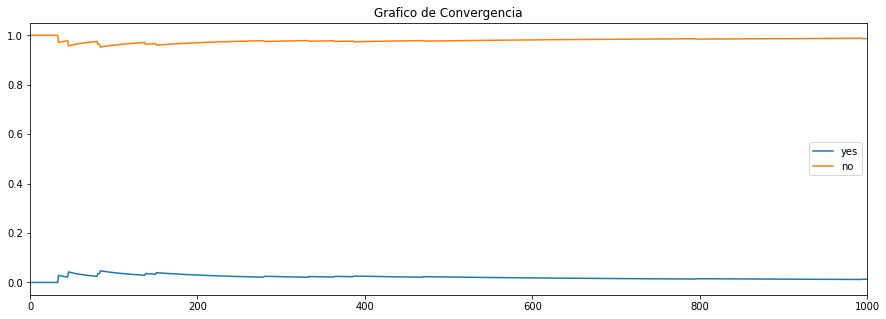

In [17]:
df = gibbs_sampling('data/ASIA/asia.bif', 1)

## Conclusão 

Com o realizar deste trabalho podemos perceber que podemos calcular os valores de probabilidade a partir da rede Bayesiana.